### Imports

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")
%matplotlib inline
import seaborn as sns

In [6]:
# Read in dataset
df = pd.read_csv('Data/BADS_WS1920_known.csv')
df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
1,2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
3,4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
4,5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


### Summary Checks

In [3]:
# Get dimensions of df and check if data has missing values
print(df.shape)
df.info()

(100000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_item_id  100000 non-null  int64  
 1   order_date     100000 non-null  object 
 2   delivery_date  90682 non-null   object 
 3   item_id        100000 non-null  int64  
 4   item_size      100000 non-null  object 
 5   item_color     100000 non-null  object 
 6   brand_id       100000 non-null  int64  
 7   item_price     100000 non-null  float64
 8   user_id        100000 non-null  int64  
 9   user_title     100000 non-null  object 
 10  user_dob       91275 non-null   object 
 11  user_state     100000 non-null  object 
 12  user_reg_date  100000 non-null  object 
 13  return         100000 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 10.7+ MB


In [4]:
# Get basic descriptive stats of numeric variables
df.describe().round(3)

,order_item_id,item_id,brand_id,item_price,user_id,return
count,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000
mean,50000.500,923.782,30.149,65.065,27169.074,0.458
std,28867.658,702.569,28.180,47.992,14053.418,0.498
min,1.000,1.000,1.000,0.000,9.000,0.000
25%,25000.750,214.000,5.000,29.900,14937.000,0.000
50%,50000.500,812.000,25.000,49.900,31189.000,0.000
75%,75000.250,1581.000,44.000,79.900,38917.250,1.000
max,100000.000,2241.000,138.000,999.000,48241.000,1.000


order_item_id, item_id, brand_id and user_id are technically all nominal categorical variables.

### Data Cleaning

**Check Legitimacy of Delivery Date**

If the product has not been delivered, then it is likely return was assumed to be = 0. This means that we should drop these rows as it will reduce the effectiveness of our model.

If instead, we find that products without a delivery date have occurences where return = 1, then we can assume it is simply missing data.

In [5]:
result = 'Products have not been delivered, therefore they cannot be returned.'

for idx, row in df[df['delivery_date'].isnull()].iterrows():
  if row['return'] == 1:
    result = 'Products may not have recorded delivery date, some products have been returned.'
    break

print(result)

Products have not been delivered, therefore they cannot be returned.


In [6]:
# No Delivery column for missing delivery date values
df['no_delivery'] = df['delivery_date'].isna().astype(int)

This is so that in the test data, we can still predict entries with missing information.

**Check Item Price**

There are some items where price = 0.

For the unsized items, we assume that these were gifts.
For sized items, because the training data only shows 1 such example, we are unsure whether it's a mistake and so we choose to drop it.

In [7]:
# Size of items where price = 0
print('No. of Unsized Items:', df[df['item_size'] == 'unsized'].shape[0])
df[df['item_price'] == 0].groupby('item_size')['item_size'].count()

No. of Unsized Items: 5223


item_size
40           1
unsized    395
Name: item_size, dtype: int64

In [8]:
# Drop items that are unsized with price = 0
print(df.shape)
df = df[~((df['item_price'] == 0) & (df['item_size'] != 'unsized'))]
df.shape

(100000, 15)


(99999, 15)

**Convert Date columns into Date type**

In [9]:
# Change str to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%Y-%m-%d')
df['delivery_date'] = pd.to_datetime(df['delivery_date'], format='%Y-%m-%d')
df['user_dob'] = pd.to_datetime(df['user_dob'], format='%Y-%m-%d') # Note, some DOB is missing
df['user_reg_date'] = pd.to_datetime(df['user_reg_date'], format='%Y-%m-%d')

type(df['order_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

**Addressing Missing User DOB values**

Considering the percentage of data that is meaning, interpolating the values may heavily skew the data (especially if featured variables like age are significant). 

We will add a missing label to featured variables as they are created.

In [10]:
round(len(df[df['user_dob'].isnull()])/len(df), 4)

0.0873

**Check Item Size**

There is a need to standardise the scale and sizings to something consistent.

- Considering that over 90% of the purchases come from female, we assume this is a female-oriented shop and thus assume female sizes.
- Looking at user states, it seems that the shop attracts European customers

These are the types of labellings in the data:
1. Int (could be size, could be waist, could be waist length, could be height)
2. Int+
3. Str

References this article, unless specified, https://en.wikipedia.org/wiki/Clothing_sizes#Women

In [11]:
# Look at unique values for item_size
df['item_size'].unique()

array(['38', '152', 'xxl', '41', '50', 'l', '48', 'xl', '42', '43', '9',
       '8+', 'unsized', 'm', 's', '40', '40+', '6+', '10', '8', '7', '44',
       '37', '39', '36', '4+', '21', '18', '7+', '20', '5+', '46', '6',
       '19', '4', '5', '35', '31', '38+', '29', '34', '3', '30', '45',
       '22', '24', '41+', '39+', '23', '140', '116', '26', '9+', '3632',
       '4032', '10+', '1', '36+', '11', '28', '11+', '12', '25', '37+',
       '128', '176', 'xs', '42+', '3432', '164', '52', '104', '33', '32',
       '14', 'xxxl', '27', '13', '56', '3+', '47', '54', '3332', '46+',
       '2', '80', '45+', '90', '3832', '3634', '44+', '49', '43+', '2+',
       '100', '3132', '58', '4034', '84', '105', '3834', '12+'],
      dtype=object)

In [12]:
# Take sizes with + as the value + 1
count = 0
for idx, row in df[df['item_size'].str.contains('+', regex=False)].iterrows():
  df.loc[idx, 'item_size'] = str(int(row['item_size'][:-1]) + 1)
  count += 1

print("Rows edited:", count)

Rows edited: 2695


In [13]:
# Dummy function that returns size based on values specified
# https://www.wikihow.com/Read-Pants-Size

def transform_size(x, size_val, size=['xs', 's', 'm', 'l', 'xl', 'xxl', 'xxxl']):
  if x <= size_val[0]:
    return size[0]
  elif x <= size_val[1]:
    return size[1]
  elif x <= size_val[2]:
    return size[2]
  elif x <= size_val[3]:
    return size[3]
  elif x <= size_val[4]:
    return size[4]
  elif x <= size_val[5]:
    return size[5]
  else:
    return size[6]

In [14]:
# Convert Pant Sizes with Length
# https://www.wikihow.com/Read-Pants-Size
size_val = [24, 26, 28, 30, 32, 34, 40]
count = 0

for idx, row in df[(df['item_size'].str.len() == 4) & (df['item_size'].str.isnumeric())].iterrows():
  df.loc[idx, 'item_size'] = transform_size(int(row['item_size'][:2]), size_val)
  count += 1

print("Rows converted:", count)

Rows converted: 93


In [15]:
# Convert Children Sizes
# https://www.mothercare.com.sg/size-charts/baby--kids-fashion/
count = 0

for idx, row in df[(df['item_size'].str.len() == 3) & (df['item_size'].str.isnumeric())].iterrows():
  if int(row['item_size']) < 116:
    pass
  else:
    df.loc[idx, 'item_size'] = 'child'
    count += 1

for idx, row in df[(df['item_size'].str.len() <= 3) & (df['item_size'].str.isnumeric())].iterrows():
  if int(row['item_size']) in (80, 90, 100, 104, 105):
    df.loc[idx, 'item_size'] = 'child'
    count += 1

print("Rows converted:", count)

Rows converted: 531


In [16]:
# Assume that values from 40 to 50 onwards are women's dress sizes
# Convert Chest Sizes
size_val = [40, 42, 44, 46, 48, 50, 54]
count = 0

for idx, row in df[(df['item_size'].str.len() == 2) & (df['item_size'].str.isnumeric())].iterrows():
  if int(row['item_size']) < 40:
    pass
  else:
    df.loc[idx, 'item_size'] = transform_size(int(row['item_size']), size_val)
    count += 1

print("Rows converted:", count)

Rows converted: 24593


In [17]:
# Assume that values between 24 and 36 are also waist sizes
# Convert Waist Sizes
size_val = [24, 26, 28, 30, 32, 34, 40]
count = 0

for idx, row in df[(df['item_size'].str.len() == 2) & (df['item_size'].str.isnumeric())].iterrows():
  if int(row['item_size']) > 40:
    pass
  else:
    df.loc[idx, 'item_size'] = transform_size(int(row['item_size']), size_val)
    count += 1

print("Rows converted:", count)

Rows converted: 19440


In [18]:
# Convert UK Numeric Sizes
size_val = [8, 10, 12, 16, 18, 20, 22]
count = 0

for idx, row in df[(df['item_size'].str.len() <= 2) & (df['item_size'].str.isnumeric())].iterrows():
  if int(row['item_size']) < 24:
      df.loc[idx, 'item_size'] = transform_size(int(row['item_size']), size_val)
      count += 1

print("Rows converted:", count)

Rows converted: 3567


In [19]:
# Check that all values have been re-categorised
df['item_size'].unique()

array(['xxxl', 'child', 'xxl', 's', 'l', 'xl', 'm', 'unsized', 'xs'],
      dtype=object)

### Feature Engineering

In [20]:
df2 = df.copy()
df2.shape

(99999, 15)

**Gender of User**

In [21]:
df2['is_female'] = (df2['user_title'] == 'Mrs').astype(int)
df2['is_male'] = (df2['user_title'] == 'Mr').astype(int)

**Age of User**

In [22]:
# Define a function to calculate age
def calculate_age(dob, order_date):
    try:
        age = (order_date - dob).days//365
        return age
    except TypeError:  # Handle NaT values
        return None

# Lambda function
df2['age'] = df.apply(lambda row: calculate_age(row['user_dob'], row['order_date']), axis=1)
df2['age'].fillna(-99, inplace=True)
df2['age'].head()

0    47.0
1    47.0
2    46.0
3    46.0
4    46.0
Name: age, dtype: float64

**Age Groups**

It may be more valuable to bin the ages by ranges.

In [23]:
# Define age bins and labels for the age groups
age_bins = [-99, -1, 21, 30, 45, 55, 65, int(df2['age'].max())+1]
age_labels = ['Missing', '21 and Under', '22-30', '31-45', '46-55', '56-65', '65 and Above']

# Age Group based on age ranges
df2['age_group'] = pd.cut(df2['age'], bins=age_bins, labels=age_labels, right=False)
df2['age_group'].head()

0    46-55
1    46-55
2    46-55
3    46-55
4    46-55
Name: age_group, dtype: category
Categories (7, object): ['Missing' < '21 and Under' < '22-30' < '31-45' < '46-55' < '56-65' < '65 and Above']

In [24]:
# Initialise dict for return=1/count
age_dict = dict()

for grp in age_labels:
    print(grp)
    df_grp = df2[df2['age_group'] == grp]
    age_dict[grp] = round(len(df_grp[df_grp['return'] == 1])/len(df_grp), 4)

print(age_dict)

Missing
21 and Under
22-30
31-45
46-55
56-65
65 and Above
{'Missing': 0.4548, '21 and Under': 0.5357, '22-30': 0.3713, '31-45': 0.4988, '46-55': 0.4653, '56-65': 0.4273, '65 and Above': 0.4267}


**Waiting Time for Delivery**

For delivery days < 0, fill with median value.

In [25]:
# Define a function to calculate waiting time
def calculate_wait(order_date, delivery_date):
  wait = (delivery_date - order_date).days

  return wait

# Lambda function
df2['delivery_days'] = df2.apply(lambda row: calculate_wait(row['order_date'], row['delivery_date']), axis=1)

# Fill negative 'delivery_days' with median
df2.loc[df2['delivery_days'] < 0, 'delivery_days'] = np.NaN
df2.loc[df2['delivery_days'].isnull(), 'delivery_days'] = df2.loc[df2['delivery_days'] >= 0, 'delivery_days'].median()
df2[df2['delivery_days'] >= 0]['delivery_days'].shape

(99999,)

**Number of Items per Order**

In [26]:
# Append the count of items by 'user_id' and 'order_date' to df
df2['no_items'] = df2.groupby(['user_id', 'order_date'])['order_item_id'].transform('count')
df2['no_items'].head()

0    2
1    2
2    9
3    9
4    9
Name: no_items, dtype: int64

**Average Monthly Freq of Purchases**

In [27]:
# Boxplot by returns function
def boxplot_br(df, var, figsize=(8,8)):
    fig, ax = plt.subplots(figsize=figsize)

    freq_dnr = df[df['return'] == 0][var]
    freq_r = df[df['return'] == 1][var]
    
    ax.boxplot([freq_dnr, freq_r])
    
    ax.set_xticklabels(['0', '1'])
    plt.title(var)
    plt.show()

In [28]:
# Group by no. of purchases
freq_purchases = df2.groupby('user_id')['order_item_id'].transform('count')

# Get range of months for data
month_to_int = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
first_month = df2['order_date'].min().month_name()
last_month = df2['order_date'].max().month_name()
val = month_to_int[last_month] - month_to_int[first_month]

df2['avg_freq_purchases'] = freq_purchases/val

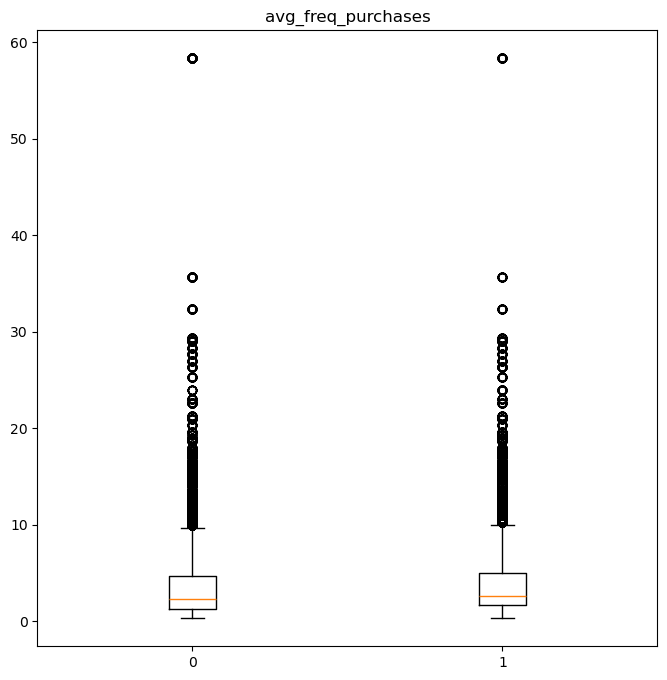

In [29]:
# Plot distribution
boxplot_br(df2, 'avg_freq_purchases')

**Special Occasion**

There could be different returns frequency during birthday, discount or gifting periods.

In [30]:
# Define specific dates for special occasions (2016 only)
occ_dates = {
    'New Year': pd.Timestamp('2016-01-01'),
    'Valentine\'s Day': pd.Timestamp('2016-02-14'),
    'Mother\'s Day': pd.Timestamp('2016-05-08'),
    'Father\'s Day': pd.Timestamp('2016-06-19'),
    'Back to School': pd.Timestamp('2016-09-01'),
    'Black Friday': pd.Timestamp('2016-11-25'),
    'Cyber Monday': pd.Timestamp('2016-11-28'),
    'Christmas': pd.Timestamp('2016-12-25')
}

In [31]:
# Function to check if order date falls within specific ranges for special occasions
def is_special(order_date):
    for occ, occ_date in occ_dates.items():
        if occ in ['Black Friday', 'Cyber Monday']:
            # Check if order date falls within 2 days before or after the holiday
            if (occ_date - pd.Timedelta(days=2)) <= order_date <= (occ_date + pd.Timedelta(days=2)):
                return occ
        else:
            # Check if order date falls within 10 days before the holiday
            if (occ_date - pd.Timedelta(days=10)) <= order_date <= occ_date:
                return occ
    
    return None

# Create a new column indicating if the order is during a special period
df2['is_special'] = df2['order_date'].apply(is_special)

**Close to user's Birthday**

In [32]:
# Orders close to birthday
df2['mdorder'] = df2['order_date'].dt.strftime("%m%d").astype(float)
df2['mddelivery'] = df2['delivery_date'].dt.strftime("%m%d").astype(float)
df2['mdbirthd'] = df2['user_dob'].dt.strftime("%m%d").astype(float)
df2['preorders'] = df2['mdbirthd'] - df2['mddelivery']
df2['is_bday'] = ((df2['preorders'] < 0) & (df2['preorders'] > -30) | ((df2['mdbirthd'] >= 1215) & (df2['mddelivery'] <= 115))).astype(int)

df2.drop(['mdorder', 'mddelivery', 'mdbirthd', 'preorders'], axis=1, inplace=True)

#### Creating and mapping training features to the entire dataset

This is to prevent data leakage/overfitting.

In [33]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = df2
y = df2['return']

X_encode, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Item Sizes with Lower Return Rate**

In [34]:
item_sum = X_encode.groupby('item_size')['return'].sum()
item_count = X_encode.groupby('item_size')['return'].count()
item_return = item_sum/item_count

item_return

item_size
child      0.215130
l          0.461464
m          0.465788
s          0.494512
unsized    0.280676
xl         0.462456
xs         0.500641
xxl        0.431702
xxxl       0.465794
Name: return, dtype: float64

In [35]:
# Create variable
df2['least_returned_size'] = df2['item_id'].isin(['child','unsized']).astype(int)

**Most Returned Items**

In [36]:
item_sum = X_encode.groupby('item_id')['return'].sum()
item_count = X_encode.groupby('item_id')['return'].count()
item_return = item_sum/item_count

count = 0
item_id_list = []

for idx in item_return.index:
    if item_return[idx] > 0.5 and item_count[idx] > 40:
        item_id_list.append(idx)
        count += 1
print(count)

265


In [37]:
# Create variable
df2['most_returned_item'] = df2['item_id'].isin(item_id_list).astype(int)

**Least Returned Items**

In [38]:
item_sum = X_encode.groupby('item_id')['return'].sum()
item_count = X_encode.groupby('item_id')['return'].count()
item_return = item_sum/item_count

count = 0
item_id_list = []

for idx in item_return.index:
    if item_return[idx] < 0.25 and item_count[idx] > 40:
        item_id_list.append(idx)
        count += 1
print(count)

58


In [39]:
# Create variable
df2['least_returned_item'] = df2['item_id'].isin(item_id_list).astype(int)

**Most Returned Colors**

In [40]:
item_sum = X_encode.groupby('item_color')['return'].sum()
item_count = X_encode.groupby('item_color')['return'].count()
item_return = item_sum/item_count

count = 0
item_id_list = []

for idx in item_return.index:
    if item_return[idx] > 0.5 and item_count[idx] > 20:
        item_id_list.append(idx)
        count += 1
print(count)

12


In [41]:
# Create variable
df2['most_returned_color'] = df2['item_color'].isin(item_id_list).astype(int)

**Least Returned Colors**

In [42]:
item_sum = X_encode.groupby('item_color')['return'].sum()
item_count = X_encode.groupby('item_color')['return'].count()
item_return = item_sum/item_count

count = 0
item_id_list = []

for idx in item_return.index:
    if item_return[idx] < 0.2 and item_count[idx] > 20:
        item_id_list.append(idx)
        count += 1
print(count)

3


In [43]:
# Create variable
df2['least_returned_color'] = df2['item_color'].isin(item_id_list).astype(int)

### Data Transformation and Standardising

**Log Transformation**

In [44]:
df3 = df2.copy()
print(df3.shape)
num_col =['item_price', 'no_items', 'delivery_days', 'age', 'avg_freq_purchases']

(99999, 29)


item_price            1.980993
no_items              2.821200
delivery_days         4.022536
age                  -2.575843
avg_freq_purchases    4.500025
dtype: float64


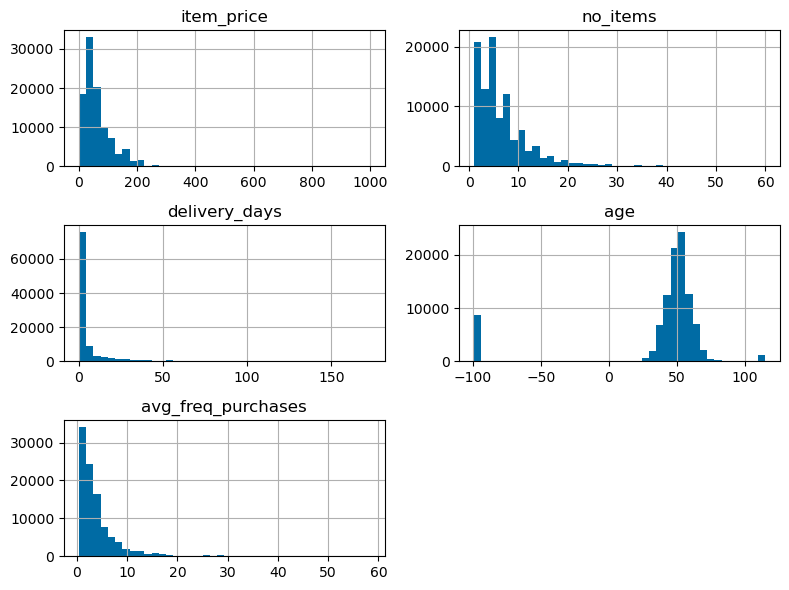

In [45]:
# Check for Skewness
print(df3[num_col].skew())
df3[num_col].hist(bins=40, figsize=(8,6))
plt.tight_layout()
plt.show()

In [46]:
# Apply Log Transformation
log_num_col = ['log_' + var for var in num_col]

for var in num_col:
    if var == 'item_price':
        df3['log_'+var] = np.log(df3[var]+10) # Account for item price = 0

    elif var == 'delivery_days':
        df3['log_'+var] = np.log(df3[var]+0.01) # Account for delivery days = 0

    else:
        df3['log_'+var] = np.log(df3[var])
    
print(df3[log_num_col].skew())
df3['log_age'].fillna(-99, inplace=True)

log_item_price            0.067159
log_no_items             -0.059183
log_delivery_days         0.433625
log_age                  -0.197428
log_avg_freq_purchases    0.049956
dtype: float64


/Users/xaviersan/miniconda3/envs/dmba/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Note that missing age values weren't dropped, hence the warning.

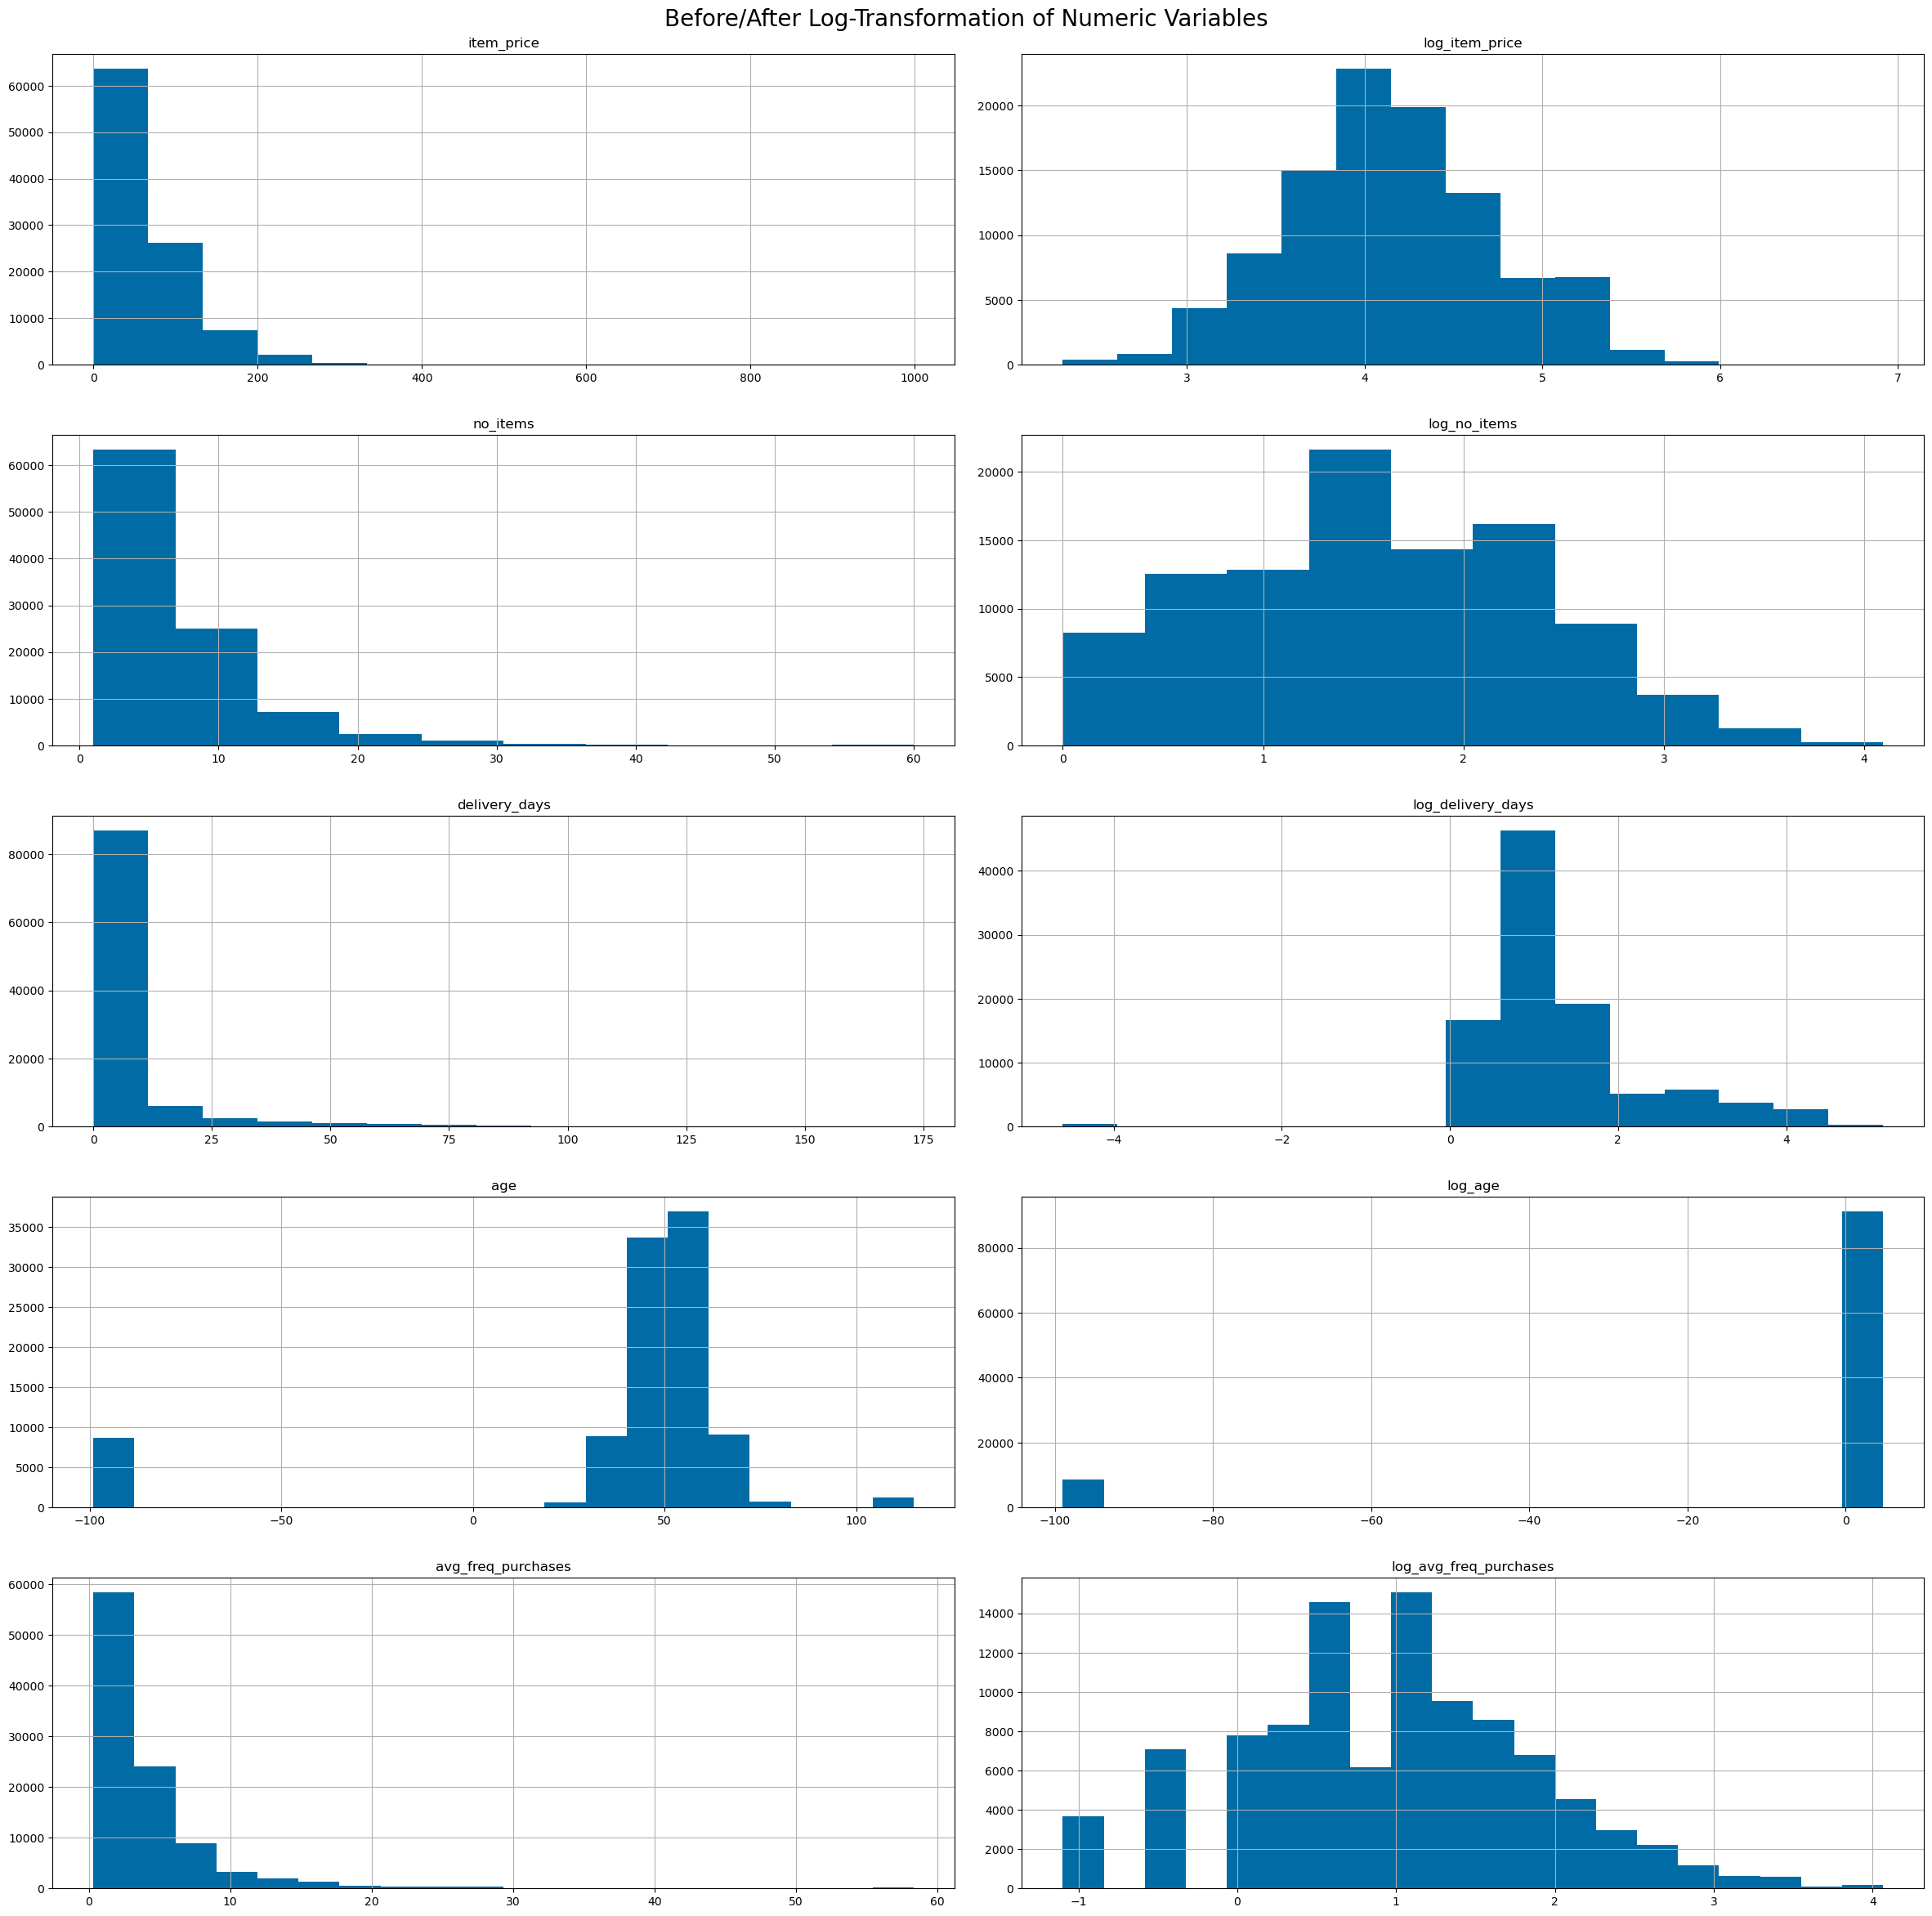

In [62]:
# Plot change in distribution of numeric variables
fig, (axes1, axes2, axes3, axes4, axes5) = plt.subplots(5, 2, figsize=(24,24))

df3.hist('item_price', ax=axes1[0], bins=15)
df3.hist('log_item_price', ax=axes1[1], bins=15)
df3.hist('no_items', ax=axes2[0], bins=10)
df3.hist('log_no_items', ax=axes2[1], bins=10)
df3.hist('delivery_days', ax=axes3[0], bins=15)
df3.hist('log_delivery_days', ax=axes3[1], bins=15)
df3.hist('age', ax=axes4[0], bins=20)
df3.hist('log_age', ax=axes4[1], bins=20)
df3.hist('avg_freq_purchases', ax=axes5[0], bins=20)
df3.hist('log_avg_freq_purchases', ax=axes5[1], bins=20)

fig.suptitle('Before/After Log-Transformation of Numeric Variables', fontsize=20)
plt.tight_layout(pad=2, h_pad=3)
plt.show()

**Normalisation**

In [48]:
# Import scaler package
from sklearn.preprocessing import StandardScaler

# Keep log variables
df_log_num = df3[log_num_col]

# Perform standardisation
scaler = StandardScaler()
scaler.fit(df_log_num)
log_num_scaled = scaler.transform(df_log_num)

In [49]:
# Convert to dataframe
df_log_num_scaled = pd.DataFrame(log_num_scaled, columns=log_num_col)
df_log_num_scaled.describe()

,log_item_price,log_no_items,log_delivery_days,log_age,log_avg_freq_purchases
count,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04
mean,9.890854e-17,2.651772e-16,2.063437e-16,1.762164e-17,-1.341518e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.148184e+00,-1.947552e+00,-5.577494e+00,-3.234306e+00,-2.237208e+00
25%,-7.842762e-01,-5.874228e-01,-5.129212e-01,3.042422e-01,-7.373692e-01
50%,-9.020021e-02,4.500116e-02,-1.272934e-01,3.086431e-01,1.255006e-02
75%,6.033996e-01,6.268857e-01,1.466449e-01,3.125446e-01,6.926447e-01
max,4.734059e+00,3.121422e+00,3.741739e+00,3.373176e-01,3.350599e+00


In [50]:
# Combine normalised variables with categorical variables
df4 = pd.concat([df3.drop(log_num_col+num_col, axis=1).reset_index(drop=True), df_log_num_scaled], axis=1)
df4.shape

(99999, 29)

### Exploratory Data Analysis

**Numerical Heatmap**

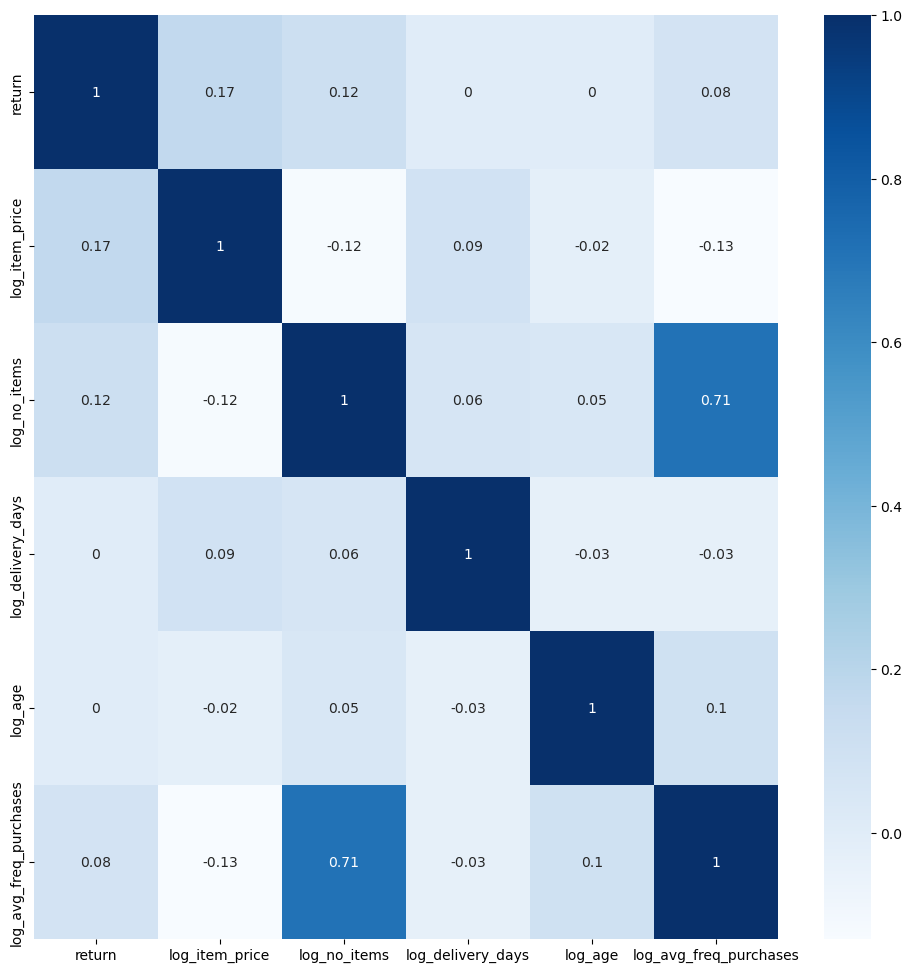

In [51]:
df_corr = df4[['return'] + log_num_col].corr()

plt.figure(figsize=(12, 12))

sns.heatmap(round(df_corr,2), annot=True, fmt='g', cmap="Blues")
plt.show()

**Boxplot by Return**

Compare most correlated with least correlated variable (log item price vs log delivery days)

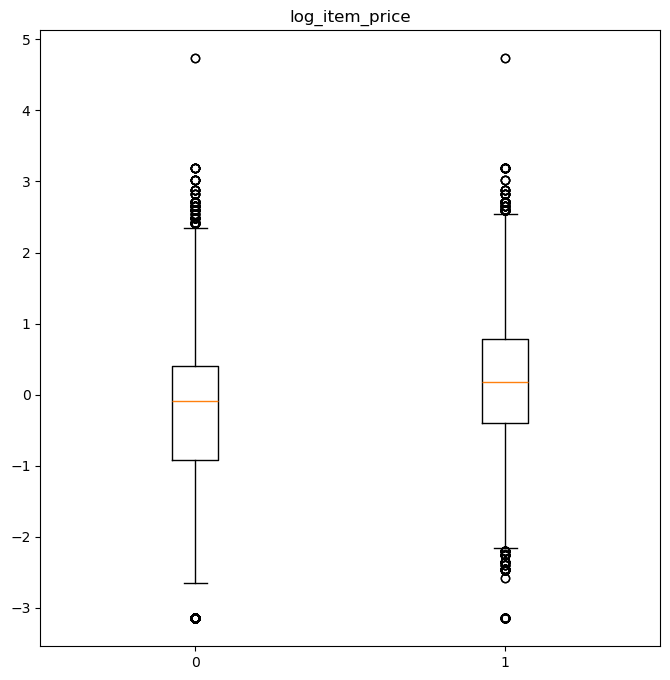

In [52]:
boxplot_br(df4, 'log_item_price')

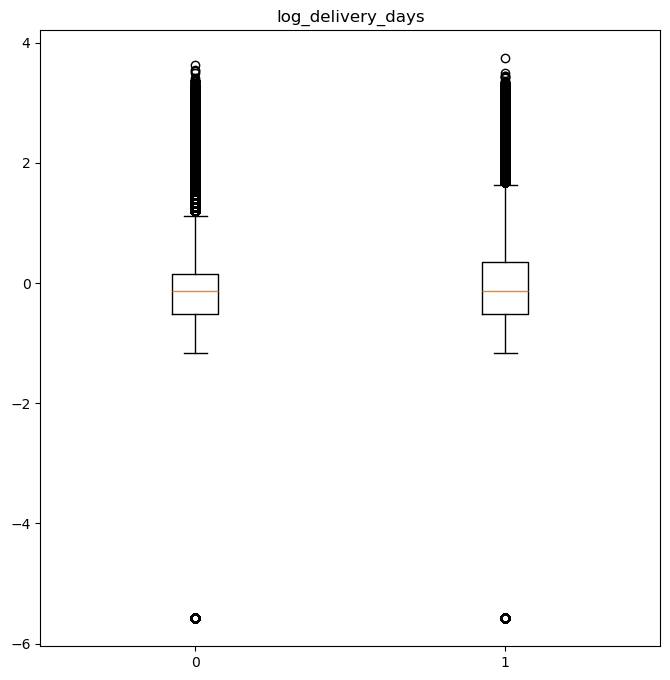

In [53]:
boxplot_br(df4, 'log_delivery_days')

**Check for Homogenous Variables**

In [54]:
homog_cols = []
for col in df4.columns:
    value_counts = df4[col].value_counts(normalize=True)
    if value_counts.max() >= 0.9:
        homog_cols.append(col)

homog_cols

['user_title',
 'no_delivery',
 'is_female',
 'is_male',
 'is_special',
 'is_bday',
 'least_returned_size',
 'least_returned_item',
 'most_returned_color',
 'least_returned_color']

Good to know, but may not necessarily drop.

**Check significance of Categorical Variables**

In [55]:
from scipy.stats import chi2_contingency

# Initialise variables
corr = []
not_corr = []
cat_var = df4.drop(log_num_col, axis=1)
col_list = list(cat_var.columns)
col_list.remove('return')

for col in col_list:
    crosstab = pd.crosstab(index=cat_var['return'],columns=cat_var[col])

    # Perform Chi-sq test
    result = chi2_contingency(crosstab)

    # Correlated
    if result[1] <= 0.01:
        corr.append(col)
    else:
        not_corr.append(col)

# Print results
print('Variables Correlated with Return:', corr)
print()
print('Variables Not Correlated with Return:', not_corr)

Variables Correlated with Return: ['order_date', 'delivery_date', 'item_id', 'item_size', 'item_color', 'brand_id', 'user_id', 'user_title', 'user_dob', 'user_state', 'user_reg_date', 'no_delivery', 'is_female', 'is_male', 'age_group', 'is_bday', 'most_returned_item', 'least_returned_item', 'most_returned_color', 'least_returned_color']

Variables Not Correlated with Return: ['order_item_id', 'is_special', 'least_returned_size']


### Prepare Output for Modelling

In [109]:
df5 = df4.copy()

**Drop Numerical Variables**

In [110]:
num_drop = ['log_delivery_days']
df5.drop(num_drop, axis=1, inplace=True)
df5.shape

(99999, 28)

**Drop Categorical Variables**

Besides the insignificant variables, we drop variables that have been engineered in some way.

In [111]:
cat_drop = ['item_id', 'item_color', 'user_title', 'order_item_id', 'order_date', 'delivery_date', 
            'user_dob', 'user_reg_date', 'age_group', 'is_special', 'least_returned_size']
df5.drop(cat_drop, axis=1, inplace=True)
df5.shape

(99999, 17)

**Encode Categorical Variables**

One-Hot Encoding

In [112]:
df5 = pd.get_dummies(df5, columns=['user_state', 'item_size'])
df5.shape

(99999, 40)

Target Encoding

Use X_encode values to prevent overfitting.

In [113]:
# Create copy for fully train-encoded dataframe
df6 = df5.copy()

In [114]:
# Calculate average return rate for each user ID
user_return_rates = X_encode.groupby('user_id')['return'].mean()

# Calculate average return rate for each brand ID
brand_return_rates = X_encode.groupby('brand_id')['return'].mean()

# Map user ID and brand ID to their corresponding return rates
df6['user_return_rate'] = df6['user_id'].map(user_return_rates)
df6['brand_return_rate'] = df6['brand_id'].map(brand_return_rates)

# Fill missing values with 0.5 (new users in test data)
df6['user_return_rate'].fillna(0.5, inplace=True)
df6['brand_return_rate'].fillna(0.5, inplace=True)

df6.drop(['user_id','brand_id'], axis=1, inplace=True)

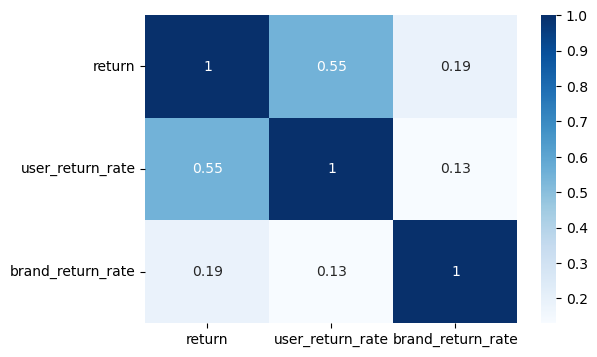

In [115]:
df_corr = df6[['return'] + ['user_return_rate','brand_return_rate']].corr()

plt.figure(figsize=(6, 4))

sns.heatmap(round(df_corr,2), annot=True, fmt='g', cmap="Blues")
plt.show()

We observe a stronger correlation between the user return rate and the occurence of an actual return, compared to the other numerical variables we compared to earlier on.

**Test Baseline (Decision Tree)**

Criteria:
- Easy to run
- Simple structure/architecture
- Interpretable (i.e. we must know why it gives particular results)
- Relatively fast
- Gives relatively good performance

In [116]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = df6.drop('return', axis=1)
y = df6['return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

classifier = DecisionTreeClassifier(criterion='entropy', random_state=1, max_features='sqrt')
classifier.fit(X_train, y_train)
 
# Making predictions on the same data
y_pred = classifier.predict(X_test)
 
# Evaluating the model
accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.6604691268928204
Precision: 0.627983358878914
Recall: 0.6319964742177171


This is the benchmark that we will aim to beat.

**Export as .csv**

In [118]:
# Convert Boolean to 0/1 for DNN
df5 = df5*1
df6 = df6*1

In [119]:
# For hyperparameter tuning
df5.to_csv('Data/cv_processed_df.csv', index=False)

# For model evaluation
df6.to_csv('Data/processed_df.csv', index=False)